
# GapMinder Model Interpretation for Pearson’s Correlation Coefficient Tests

In [1]:

import pickle
import pandas as pd

# Handy list of the different types of encodings
encoding = ['latin1', 'iso8859-1', 'utf-8'][1]

# Change this to your data and saves folders
data_folder = r'../../data/'
saves_folder = r'../../saves/'

def load_object(obj_name):
    pickle_path = saves_folder + 'pickle/' + obj_name + '.pickle'
    try:
        object = pd.read_pickle(pickle_path)
    except:
        with open(pickle_path, 'rb') as handle:
            object = pickle.load(handle)
    
    return(object)

In [2]:

from sklearn.decomposition import PCA
import os

obj_path = saves_folder + 'pickle/gapminder_df.pickle'
if not os.path.isfile(obj_path):
    gapminder_df = pd.read_csv(data_folder + 'csv/gapminder.csv',
                               low_memory=False, encoding=encoding)
else:
    gapminder_df = load_object('gapminder_df')
gapminder_df.columns = ['country_name', 'income_per_person',
                        'alcohol_consumption', 'armed_forces_rate',
                        'breast_cancer_per_100th', 'co2_emissions',
                        'female_employment_rate', 'hiv_rate',
                        'internet_use_rate', 'life_expectancy',
                        'oil_per_person', 'polity_score',
                        'residential_electricity_per_person',
                        'suicide_per_100th', 'employment_rate',
                        'urban_rate']
number_column_list = list(set(gapminder_df.columns) - set(['country_name']))
elite_df = gapminder_df.dropna(how='any').copy()
elite_ndarray = PCA(n_components=2).fit_transform(elite_df[number_column_list])

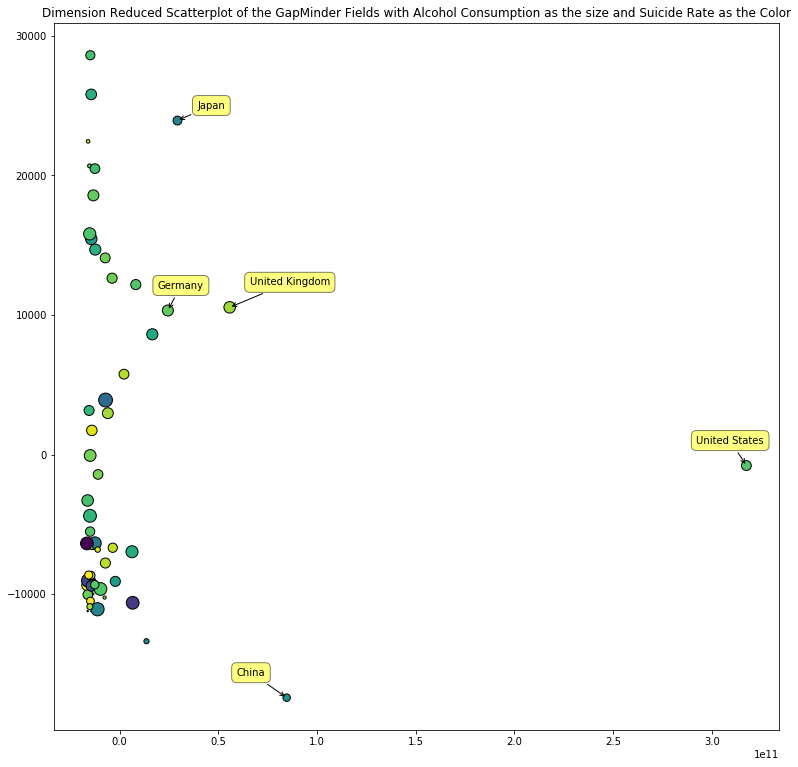

In [3]:

%matplotlib inline
import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=7750000000, min_samples=2).fit(elite_ndarray)
labels = db.labels_

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, autoscale_on=True)
cmap = plt.get_cmap('viridis_r')
path_collection = ax.scatter(elite_ndarray[:, 0], elite_ndarray[:, 1],
                             s=elite_df['alcohol_consumption']*10,
                             c=elite_df['suicide_per_100th'],
                             edgecolors=(0, 0, 0), cmap=cmap)
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
for col, label, x, y in zip(labels, elite_df['country_name'],
                            elite_ndarray[:, 0], elite_ndarray[:, 1]):
    if (label == 'Japan'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 10), **kwargs)
    elif (label == 'United Kingdom'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 20), **kwargs)
    elif (label == 'China') or (label == 'United States'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-50, 20), **kwargs)
    elif (col == 1):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-10, 20), **kwargs)
title_text = 'Dimension Reduced Scatterplot of the GapMinder '
title_text += 'Fields with Alcohol Consumption as the size and '
title_text += 'Suicide Rate as the Color'
text = plt.title(title_text)

In [4]:

%matplotlib inline
from IPython.display import HTML
from scipy.stats import pearsonr
import seaborn as sns

# Pearson’s Correlation Coefficient
def model_interpretation(df,
                         qe_column, qr_column,
                         qe_formal_name, qr_formal_name,
                         qe_informal_name, qr_informal_name,
                         sample_name='the population', verbose=False):
    
    # Quantitative explanatory variable
    df[qe_column] = df[qe_column].astype('float64')
    
    # Quantitative response variable
    df[qr_column] = df[qr_column].astype('float64')
    
    pearsonr_tuple = pearsonr(df[qe_column], df[qr_column])
    if verbose:
        print()
        print('Association between ' + qe_informal_name + ' and ' + qr_informal_name)
        explanation_list = ['Pearson’s correlation coefficient', '2-tailed p-value']
        for x, y in zip(explanation_list, pearsonr_tuple):
            print('{}: {}'.format(x, y))
    
    # Get statements
    pearson_r = pearsonr_tuple[0]
    if pearson_r > 0:
        adjective_positive = 'positive'
    else:
        adjective_positive = 'negative'
    pearsonr_statement = str('%.2f' % pearson_r)
    coefficient_of_determination = pearson_r**2
    if coefficient_of_determination >= 0.25:
        adverb_strong = 'strongly'
    else:
        adverb_strong = 'weakly'
    percent_predictable = coefficient_of_determination*100
    cod_statement = str('%.2f' % coefficient_of_determination)
    percent_statement = str('%.1f' % percent_predictable)
    p_value = pearsonr_tuple[1]
    if p_value < 0.0001:
        pvalue_statement = '<0.0001'
    else:
        pvalue_statement = '=' + str('%.4f' % p_value)
    if p_value < 0.05:
        adverb_significant = 'significantly'
    else:
        adverb_significant = 'insignificantly'
    notebook_title_HTML = '<h3>Model Interpretation for Pearson’s Correlation Coefficient Tests:</h3>'
    pearsonr_HTML = (notebook_title_HTML + '<p>The Pearson’s Correlation Coefficient revealed that among ' +
                sample_name + ', ' +
                qe_formal_name + ' (quantitative explanatory variable), and ' +
                qr_formal_name + ' (quantitative response variable) were ' +
                adverb_significant + ' associated, in a ' +
                adverb_strong + ' ' +
                adjective_positive + r' manner, $r=' +
                pearsonr_statement + ', p' +
                pvalue_statement + r'$. This means that if we can predict the ' +
                qe_informal_name + ', we can predict ' +
                percent_statement + '% of the ' +
                qr_informal_name + '.</p>')
    
    if verbose:
        print()
        axes_subplot1 = sns.regplot(x=qe_column, y=qr_column, fit_reg=True, data=df)
        plot_title_text = ('Scatterplot for the association between ' +
                           qe_informal_name + ' and ' +
                           qr_informal_name)
        set_list = axes_subplot1.set(xlabel=qe_formal_name + ' (Explanatory Variable)',
                                     ylabel=qr_formal_name + ' (Response Variable)',
                                     title=plot_title_text)
        set_list = axes_subplot1.figure.set(figheight=10, figwidth=10)
        annotation_text = (r'$r^2=' +
                           cod_statement + ',\ p' +
                           pvalue_statement + r'$')
        set_list = axes_subplot1.figure.text(0.135, 0.86, annotation_text)
    
    return HTML(pearsonr_HTML)


Association between alcohol consumption and suicide rate
Pearson’s correlation coefficient: 0.4583425054613134
2-tailed p-value: 0.0003817876696601684



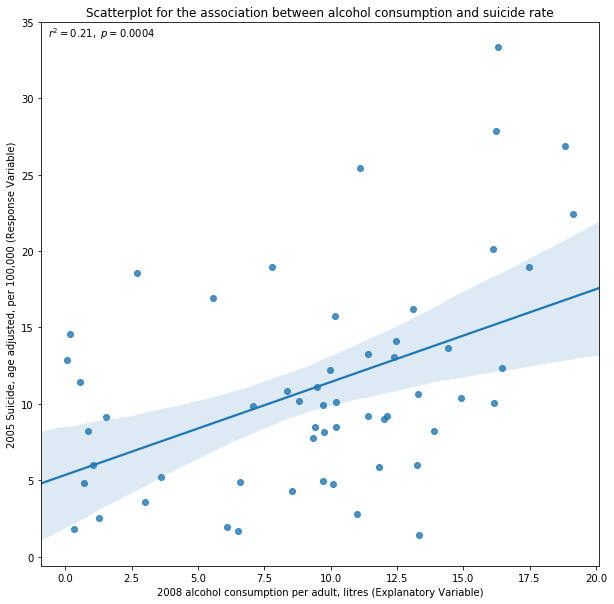

In [5]:

sample_name = 'the sample of ' + str(elite_df.shape[0]) + ' countries from GapMinder.org'
model_interpretation(elite_df,
                     'alcohol_consumption', 'suicide_per_100th',
                     '2008 alcohol consumption per adult, litres', '2005 Suicide, age adjusted, per 100,000',
                     'alcohol consumption', 'suicide rate',
                     sample_name, verbose=True)

In [6]:

%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "notebook_path = " + "'"+attribs['data-notebook-path'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [7]:
# %load ../../../load_magic/nbviewer.py

from IPython.display import HTML

notebook_viewer_url = 'https://nbviewer.jupyter.org/github/dbabbitt/notebooks/blob/master/' + notebook_path
HTML('Click <a href="' + notebook_viewer_url + '" target="_blank">here</a> to view notebook in nbviewer.')